In [12]:
import os
from skimage import data, io, filters
# import cv2
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from PIL import Image
import skimage.color
#import cv2
from torch import nn
import torch

import torch.optim as optim
import torch.nn.functional as F
#from mxnet.gluon.model_zoo import vision

# os.chdir('C:/Users/Frank/Desktop/DeepLearning/Week 5')


In [13]:


def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train(mode = True)
    stasiscounter =0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
#         print(output.shape)
#         print(target.shape)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

In [92]:
# path = 'C:/Users/Frank/Desktop/DeepLearning/Week 5/data/flowersstuff'
# trainpath = path+'/trainfile.txt'
# testpath = path+'/testfile.txt'
# valpath = path+'/valfile.txt'
# valtestpath = path+'/valtestfile.txt'
# labelpath = path+'/imagelabels.npy'

def txtToList(path):
    ls = []
    with open(path,'r') as fdata:
        txtstr=fdata.read()
#         print(txtstr)
#         aString.startswith("hello")
    ls = txtstr.split('\n')
    for i in range(len(ls)):
        if ls[i].startswith("image"):
            pass
        else:
            ls.pop(i)
    return ls


# trainfile_list = txtToList(trainpath)
# # print(trainfile_list)
# for i in trainfile_list:
#     if i.startswith("image"):
#         pass
#     else:
#         print('something wrong', i)
# testfile_list = txtToList(testpath)
# valfile_list = txtToList(valpath)
# valtestfile_list = txtToList(valtestpath)

# length = len(trainfile_list)+len(testfile_list) + len(valfile_list)# + len(valtestfile_list)
# print(length)
# labels = np.load(labelpath)
# print(labels.shape)
# image, label = (trainfile_list[0].split())
# print(image,label)
#image starts with 00001 so need to minus 1.
# inside the list it is 'image_01104.jpg 45', 'image_00517.jpg 87', 'image_06812.jpg 20', 'image_02973.jpg 59',...
# print(labels[1104-1])
# inside labels it is 76 ..... 61

In [109]:


import numpy as np
#from mxnet.gluon.model_zoo import vision


class flowersDataset(Dataset):
    '''trainpath,testpath,valpath,valtestpath,label_path,'''
    def __init__(self,imagename_list,transform = None):
#         self.trainpath = trainpath
#         self.testpath = testpath
#         self.valpath = valpath
#         self.valtestpath = valtestpath
        self.imagelabel_list = imagename_list
#         self.label = np.load(label_path)
        self.transformations = transform                                

    

    def __len__(self):
#         if (len(self.imagelabel_list)>2500):
#             return 250
#         else:
#             return(len(self.imagelabel_list))
        
        return(len(self.imagelabel_list))
    
    def __getitem__(self,index):
#         path = 'C:/Users/Frank/Desktop/DeepLearning/Week 5/data/flowersstuff/102flowers/flowers_data/jpg/'
        path = '/home/ubuntu/data/flowersstuff/102flowers/flowers_data/jpg/'
#         print(self.imagelabel_list[index])
#         if self.imagelabel_list[index]
        imagename,label = self.imagelabel_list[index].split()
        image = Image.open(path + imagename)
#         image = image.convert('RGB')
#         print(transforms.ToTensor()(image))
        
#         print(image.size)
        
        if self.transformations:
            image = self.transformations(image)
#             print('transform')
#         print(image)
        return image,int(label)

In [110]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train(mode = True)
    stasiscounter =0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
#         if(data.shape[0] != 4 or data.shape[1] != 3 or data.shape[2] != 224 or data.shape[3]!= 224):
#             print(data.shape)
        optimizer.zero_grad()
        output = model(data)
#         print(output.shape)
#         print(target.shape)
#         loss = nn.CrossEntropyLoss(output, target)
        loss = F.cross_entropy(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()
#     return 1

In [111]:
no_classes = 102

def test(args, model, device, test_loader,testOrVal):
    model.train(mode=False)
    model.eval()
    confusion_matrix=torch.zeros(no_classes,no_classes)
    test_loss = 0
    correct = 0
#     loss = nn.CrossEntropyLoss()
    with torch.no_grad():
        for i ,(data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            for t,p in zip(target.view(-1),pred.view(-1)):
                confusion_matrix[t.long(),p.long()] +=1
            
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    accuracy = 100. * correct / len(test_loader.dataset)
    
    if (testOrVal == 'test'):
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
        
    elif (testOrVal == 'val'):
        print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss, confusion_matrix, accuracy

In [112]:
def obtainLoader(file_list,batch_size,transform):
    imagelabel = flowersDataset(file_list,transform)                                  
    imagelabel_loader = torch.utils.data.DataLoader(dataset=imagelabel,
                                                        batch_size=batch_size,
                                                        shuffle=True)

    return imagelabel_loader

# frozen_resnet = torchvision.models.resnet18(pretrained = True)
# for p in frozen_resnet.conv1.parameters(): #freeze conv1
#     p.requires_grad_(False)
# for p in frozen_resnet.layer1.parameters(): #freeze layer 1
#     p.requires_grad_(False)
# for p in frozen_resnet.layer2.parameters(): # freeze Layer 2
#     p.requires_grad_(False)
# for p in frozen_resnet.layer3.parameters():
#     p.requires_grad_(False)

In [116]:
import torchvision.models as models
def main(problem):
    
    epochs = 30
    
    log_interval=10
    save_model = True
    
    lr = 0.01
    momentum = 0.01
    
#     lt = 8
#     cntr = 0

#     for child in model.children(): # model_ft.children() return a list of layer
#         cntr += 1
#         if cntr < lt: # unfreeze last 3 layers (the 2nd last layer is AvgPool2d which doesnt need for training)
#             for param in child.parameters():
#                 param.requires_grad = False # freeze the parameter or the layer so that it wont get trained

#     num_ftrs = model.fc.in_features
#     model.fc = nn.Linear(num_ftrs, 102) # convert fully connected layer (the last layer) with input of 512 and output 102 (previously input is still 512, but the output is 1000)

    
#     path ='C:/Users/Frank/Desktop/DeepLearning/Week 5/data/flowersstuff'
    path = '/home/ubuntu/data/flowersstuff'
    trainpath = path+'/trainfile.txt'
    testpath = path+'/testfile.txt'
    valpath = path+'/valfile.txt'
    valtestpath = path+'/valtestfile.txt'
    labelpath = path+'/imagelabels.npy'

    trainfile_list = txtToList(trainpath)
    testfile_list = txtToList(testpath)
    valfile_list = txtToList(valpath)
    valtestfile_list = txtToList(valtestpath)
    
#     print(trainfile_list[0].split())

    
#     device = torch.device("cuda")
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print('cuda',use_cuda)
    
    batchsize = 4
    my_transform = transforms.Compose([
        transforms.Resize(280),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ])
    #Problem 1:,   
#                                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #train file
    imagelabel_train_loader = obtainLoader(trainfile_list,batchsize,my_transform)
    
#     imagelabel_trainP1 = flowersDataset(trainfile_list,transforms.Compose([transforms.Resize(dim),
#                                                       transforms.CenterCrop(dim),
#                                                         transforms.ToTensor(),   
#                                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
#                                    )
#     imagelabel_train_loaderP1 = torch.utils.data.DataLoader(dataset=imagelabel_trainP1,
#                                                         batch_size=10,
#                                                         shuffle=False)

    #test file
    
    imagelabel_test_loader =  obtainLoader(testfile_list,batchsize,my_transform)
#     imagelabel_testP1 = flowersDataset(testfile_list,transforms.Compose([transforms.Resize(dim),
#                                                       transforms.CenterCrop(dim),
#                                                         transforms.ToTensor(),   
#                                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
#                                    )
    
#     imagelabel_test_loaderP1 = torch.utils.data.DataLoader(dataset=imagelabel_testP1,
#                                                         batch_size=10,
#                                                         shuffle=False)

    
    #val file
    imagelabel_val_loader = obtainLoader(valfile_list,batchsize,my_transform)
#     imagelabel_valP1= flowersDataset(valfile_list,transforms.Compose([transforms.Resize(dim),
#                                                       transforms.CenterCrop(dim),
#                                                         transforms.ToTensor(),   
#                                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
#                                    )    
    
    
#     imagelabel_val_loaderP1 = torch.utils.data.DataLoader(dataset=imagelabel_valP1,
#                                                         batch_size=10,
#                                                         shuffle=False)

    
    
    #valtest file
    imagelabel_valtest_loader = obtainLoader(valtestfile_list,batchsize,my_transform)
    
#     imagelabel_valtestP1 = flowersDataset(valtestfile_list,transforms.Compose([transforms.Resize(dim),
#                                                       transforms.CenterCrop(dim),
#                                                         transforms.ToTensor(),   
#                                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
#                                    )
#     imagelabel_valtest_loaderP1 = torch.utils.data.DataLoader(dataset=imagelabel_valtestP1,
#                                                         batch_size=10,
#                                                         shuffle=False)

    
    best_confusion_matrix = []
    least_loss = 10000 #best loss
    train_loss=[]
    val_loss=[]
    accuracy_list = []
    best_accuracy = 0
    best_model = None
    
    #### EPOCH TRAINING AND VALIDATION PROBLEM 1 #####
    
    if (problem == '1'):
        print('PROBLEM 1:')
        model1 = models.resnet18(pretrained=False).to(device)
        num_ftrs = model1.fc.in_features
        model1.fc = nn.Linear(num_ftrs, 102)

    
        optimizer = optim.SGD(model1.parameters(), lr=lr, momentum=momentum)
#         best_confusion_matrix = []
#         least_loss = 10000 #best loss
#         train_loss=[]
#         val_loss=[]
#         best_accuracy = 0
#         best_model = None
        
        for epoch in range(1, epochs + 1):
            train_loss.append(train(log_interval, model1, device, imagelabel_train_loader, optimizer, epoch))
            test_loss, confusion_matrix, accuracy = test(log_interval, model1, device, imagelabel_val_loader,'val')
            val_loss.append(test_loss)
            accuracy_list.append(accuracy)
            if test_loss < least_loss:
                least_loss = test_loss
                best_epoch=epoch
                best_confusion_matrix = confusion_matrix
                best_accuracy = accuracy
                best_model = model1.state_dict()
        if (save_model):
            torch.save(best_model,"Week5_1.pt")
    
    print('-' * 50)
    
    #### EPOCH TRAINING AND VALIDATION PROBLEM 2 #####
    
    if (problem == '2'):
        print("PROBLEM 2:")
        model2 = models.resnet18(pretrained=True).to(device)
        num_ftrs = model2.fc.in_features
        model2.fc = nn.Linear(num_ftrs, 102)

        optimizer = optim.SGD(model2.parameters(), lr=lr, momentum=momentum)
#         best_confusion_matrix = []
#         least_loss = 10000 #best loss
#         train_loss=[]
#         val_loss=[]
#         best_accuracy = 0
#         best_model = None
        for epoch in range(1, epochs + 1):
            train_loss.append(train(log_interval, model2, device, imagelabel_train_loader, optimizer, epoch))
            test_loss, confusion_matrix, accuracy = test(log_interval, model2, device, imagelabel_val_loader,'val')
            val_loss.append(test_loss)
            accuracy_list.append(accuracy)
            if test_loss < least_loss:
                least_loss = test_loss
                best_epoch=epoch
                best_confusion_matrix = confusion_matrix
                best_accuracy = accuracy
                best_model = model2.state_dict()
        if (save_model):
            torch.save(best_model,"Week5_2.pt")
        
    print('-' * 50)
    
    #### EPOCH TRAINING AND VALIDATION PROBLEM 3 #####
    
    if (problem == '3'):
        
        print("PROBLEM 3:")
        model3 = models.resnet18(pretrained=True).to(device)
        
        lt = 8
        cntr = 0

        for child in model3.children(): # model_ft.children() return a list of layer
            cntr += 1
            if cntr < lt: # unfreeze last 3 layers (the 2nd last layer is AvgPool2d which doesnt need for training)
                for param in child.parameters():
                    param.requires_grad = False # freezing
                    
        num_ftrs = model3.fc.in_features
        model3.fc = nn.Linear(num_ftrs, 102)

        optimizer = optim.SGD(model3.parameters(), lr=lr, momentum=momentum)
#         best_confusion_matrix = []
#         least_loss = 10000 #best loss
#         train_loss=[]
#         val_loss=[]
#         accuracy_list = []
#         best_accuracy = 0
#         best_model = None
        for epoch in range(1, epochs + 1):
            train_loss.append(train(log_interval, model3, device, imagelabel_train_loader, optimizer, epoch))
            test_loss, confusion_matrix, accuracy = test(log_interval, model3, device, imagelabel_val_loader,'val')
            val_loss.append(test_loss)
            accuracy_list.append(accuracy)
            if test_loss < least_loss:
                least_loss = test_loss
                best_epoch=epoch
                best_confusion_matrix = confusion_matrix
                best_accuracy = accuracy
                best_model = model3.state_dict()
        if (save_model):
            torch.save(best_model,"Week5_3.pt")
#     per_class_accuracy = per_class_accuracy(best_confusion_matrix)
    return accuracy_list,best_confusion_matrix, least_loss,best_epoch,train_loss,val_loss, best_accuracy, best_model
    
    
    
# if __name__ == '__main__':
#     main()

In [117]:
accuracy_list1,best_confusion_matrix1, least_loss1,best_epoch1,train_losses1,valid_losses1, best_accuracy1, best_model1 = main('1')
accuracy_list2,best_confusion_matrix2, least_loss2,best_epoch2,train_losses2,valid_losses2, best_accuracy2, best_model2 = main('2')
accuracy_list3,best_confusion_matrix3, least_loss3,best_epoch3,train_losses3,valid_losses3, best_accuracy3, best_model3 = main('3')

PROBLEM 1:
Train Epoch: 1 [0/250 (0%)]	Loss: 4.693377

Val set: Average loss: 4.9007, Accuracy: 12/1224 (1%)

Train Epoch: 2 [0/250 (0%)]	Loss: 4.257237

Val set: Average loss: 5.3505, Accuracy: 14/1224 (1%)

Train Epoch: 3 [0/250 (0%)]	Loss: 4.059825

Val set: Average loss: 5.3457, Accuracy: 23/1224 (2%)

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
PROBLEM 2:
Train Epoch: 1 [0/250 (0%)]	Loss: 5.284879

Val set: Average loss: 4.1295, Accuracy: 168/1224 (14%)

Train Epoch: 2 [0/250 (0%)]	Loss: 3.308710

Val set: Average loss: 3.7704, Accuracy: 268/1224 (22%)

Train Epoch: 3 [0/250 (0%)]	Loss: 1.773480

Val set: Average loss: 3.4400, Accuracy: 395/1224 (32%)

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
PROBLEM 3:
Train Epoch: 1 [0/250 (0%)]	Loss: 5.091377

Val set: Average 

PROBLEM 1:


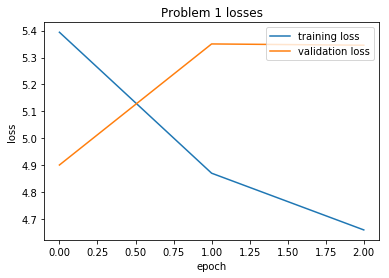

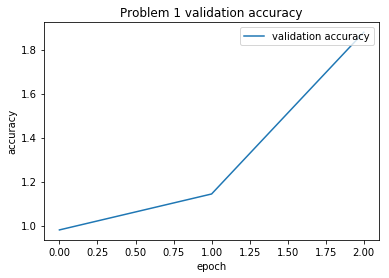

--------------------------------------------------
PROBLEM 2:


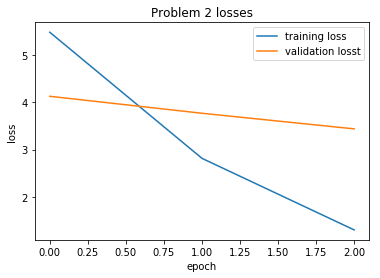

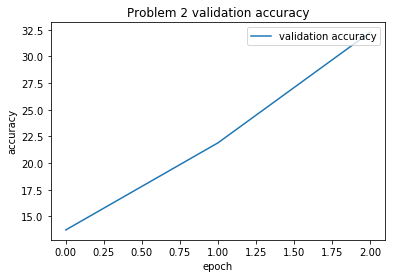

--------------------------------------------------
PROBLEM 3:


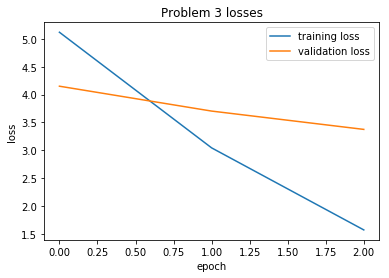

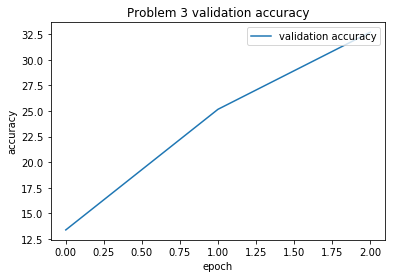

In [121]:
'''
best_confusion_matrix1, least_loss1,best_epoch1,train_loss1,val_loss1, best_accuracy1, best_model1 = main('1')
best_confusion_matrix2, least_loss2,best_epoch2,train_loss2,val_loss2, best_accuracy2, best_model2 = main('2')
best_confusion_matrix3, least_loss3,best_epoch3,train_loss3,val_loss3, best_accuracy3, best_model3 = main('3')
'''
import matplotlib.pyplot as plt

print("PROBLEM 1:")
plt.plot(train_losses1)
plt.plot(valid_losses1)

plt.title('Problem 1 losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()


plt.plot(accuracy_list1)
plt.title('Problem 1 validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation accuracy'], loc='upper right')
plt.show()



print('-' * 50)


print("PROBLEM 2:")
plt.plot(train_losses2)
plt.plot(valid_losses2)

plt.title('Problem 2 losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation losst'], loc='upper right')
plt.show()

plt.plot(accuracy_list2)
plt.title('Problem 2 validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation accuracy'], loc='upper right')
plt.show()

print('-' * 50)

print("PROBLEM 3:")
plt.plot(train_losses3)
plt.plot(valid_losses3)

plt.title('Problem 3 losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()


plt.plot(accuracy_list3)
plt.title('Problem 3 validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation accuracy'], loc='upper right')
plt.show()

In [137]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print('cuda',use_cuda)

model1 = models.resnet18(pretrained=False).to(device)
num_ftrs = model1.fc.in_features
model1.fc = nn.Linear(num_ftrs, 102)
model1.load_state_dict(torch.load('Week5_1.pt'))

                       

model2 = models.resnet18(pretrained=True).to(device)
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 102)                  
model2.load_state_dict(torch.load('Week5_2.pt'))


                    
model3 = models.resnet18(pretrained=True).to(device)
        
lt = 8
cntr = 0

for child in model3.children(): # model_ft.children() return a list of layer
    cntr += 1
    if cntr < lt: # unfreeze last 3 layers (the 2nd last layer is AvgPool2d which doesnt need for training)
        for param in child.parameters():
            param.requires_grad = False # freezing
                    
num_ftrs = model3.fc.in_features
model3.fc = nn.Linear(num_ftrs, 102)
model3.load_state_dict(torch.load('Week5_3.pt'))                   
                       

# path ='C:/Users/Frank/Desktop/DeepLearning/Week 5/data/flowersstuff'
path = '/home/ubuntu/data/flowersstuff'
testpath = path+'/testfile.txt'
testfile_list = txtToList(testpath)
batchsize = 4
my_transform = transforms.Compose([
        transforms.Resize(280),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ])
imagelabel_test_loader =  obtainLoader(testfile_list,batchsize,my_transform)
log_interval=10

print("PROBLEM 1")
testloss_1, confusionmatrix_1, testAccuracy_1 = test(log_interval,model1,device,imagelabel_test_loader,'test')

print('-' * 50)
print("PROBLEM 2:")
testloss_2, confusionmatrix_2, testAccuracy_2 = test(log_interval,model2,device,imagelabel_test_loader,'test')


print('-' * 50)
print("PROBLEM 3:")
testloss_3, confusionmatrix_3, testAccuracy_3 = test(log_interval,model3,device,imagelabel_test_loader,'test')
'''
print('-' * 50)

print("PROBLEM 1:")
plt.plot(testAccuracy_1)
plt.plot(accuracy_list1)

plt.title('Problem 1 accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation accuracy','test accuracy'], loc='upper right')
plt.show()


print('-' * 50)

print("PROBLEM 2:")

plt.plot(testAccuracy_2)
plt.plot(accuracy_list2)


plt.title('Problem 2 accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation accuracy','test accuracy'], loc='upper right')
plt.show()

print('-' * 50)

print("PROBLEM 3:")
plt.plot(testAccuracy_3)
plt.plot(accuracy_list3)

plt.title('Problem 3 accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation accuracy','test accuracy'], loc='upper right')
plt.show()
'''
def Average(lst): 
    return sum(lst) / len(lst) 
print(Average(accuracy_list1))
print(Average(accuracy_list2))
print(Average(accuracy_list3))

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/data/flowersstuff/testfile.txt'

In [3]:

import string
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(n_letters)

57
